In [7]:
from google.colab import files
import os

# Create a folder in Colab to store uploaded images
dataset_folder = "/content/Dataset"
os.makedirs(dataset_folder, exist_ok=True)

# Upload files (you can select multiple images)
uploaded = files.upload()

Saving Farmland_1.bmp to Farmland_1 (1).bmp
Saving Farmland_2.bmp to Farmland_2 (1).bmp
Saving Farmland_gt.bmp to Farmland_gt (1).bmp
Saving ottawa_1.bmp.jpeg to ottawa_1.bmp (1).jpeg
Saving ottawa_2.bmp.jpeg to ottawa_2.bmp (1).jpeg
Saving ottawa_gt.bmp.jpeg to ottawa_gt.bmp (1).jpeg
Saving san_1Before.bmp to san_1Before (1).bmp
Saving san_2After.bmp to san_2After (1).bmp
Saving san_gt.bmp to san_gt (1).bmp
Saving Sulzberger1_1Before.bmp to Sulzberger1_1Before (1).bmp
Saving Sulzberger1_2After.bmp to Sulzberger1_2After (1).bmp
Saving Sulzberger1_gt.bmp to Sulzberger1_gt (1).bmp
Saving Yellow_River_1Before.bmp to Yellow_River_1Before (1).bmp
Saving Yellow_River_2After.bmp to Yellow_River_2After (1).bmp
Saving Yellow_River_gt.bmp to Yellow_River_gt (1).bmp


In [24]:
import os

dataset_folder = "/content/Dataset"
all_files = os.listdir(dataset_folder)

# Rename files to remove " (1)" and extra spaces
for f in all_files:
    new_name = f.replace(" (1)", "").replace(" ", "")
    os.rename(os.path.join(dataset_folder, f), os.path.join(dataset_folder, new_name))

# Check files after renaming
all_files = os.listdir(dataset_folder)
print("Files after renaming:")
print(all_files)


Files after renaming:
['Farmland_gt.bmp', 'ottawa_2.bmp.jpeg', 'san_2After.bmp', 'Sulzberger1_2After.bmp', 'san_1Before.bmp', 'Yellow_River_gt.bmp', 'Farmland_1.bmp', 'ottawa_gt.bmp.jpeg', 'ottawa_1.bmp.jpeg', 'san_gt.bmp', 'Yellow_River_2After.bmp', 'Yellow_River_1Before.bmp', 'Farmland_2.bmp', 'Sulzberger1_gt.bmp', 'Sulzberger1_1Before.bmp']


In [37]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [26]:
dataset_folder = "/content/Dataset"

In [38]:
all_files = os.listdir(dataset_folder)

In [39]:
datasets = set()
for f in all_files:
    # take first part before '_' as dataset name
    if f.endswith(('.bmp', '.jpeg')):
        ds_name = f.split('_')[0]
        datasets.add(ds_name)

In [40]:
datasets = sorted(list(datasets))
print("Datasets detected:", datasets)

Datasets detected: ['Farmland', 'Sulzberger1', 'Yellow', 'ottawa', 'san']


In [41]:
def get_image_paths(ds):
    img1, img2, gt = None, None, None
    for f in all_files:
        if f.startswith(ds):
            if 'gt' in f.lower():
                gt = os.path.join(dataset_folder, f)
            elif '1' in f or 'Before' in f:
                img1 = os.path.join(dataset_folder, f)
            elif '2' in f or 'After' in f:
                img2 = os.path.join(dataset_folder, f)
    return img1, img2, gt

In [42]:
def speckle_noise_reduction(img):
    # Median filter for SAR speckle noise
    return cv2.medianBlur(img, 3)

In [43]:
def preprocess(img_path, size=(128,128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = speckle_noise_reduction(img)
    img = cv2.resize(img, size)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)  # add channel
    return img

In [44]:
def preprocess_gt(gt_path, size=(128,128)):
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    gt = cv2.resize(gt, size)
    gt = (gt > 0).astype(np.float32)
    gt = np.expand_dims(gt, axis=-1)
    return gt

In [45]:
def build_unet(input_size=(128,128,1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u2 = layers.UpSampling2D(2)(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D(2)(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet = build_unet()
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,985 (460.88 KB)

 Trainable params: 117,985 (460.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1340 - loss: 0.6970
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9265 - loss: 0.6875
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9301 - loss: 0.6775
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9301 - loss: 0.6599
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9301 - loss: 0.6243
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9301 - loss: 0.5590
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9301 - loss: 0.4563
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9301 - loss: 0.3488
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9301 - loss: 0.3685
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9301 - loss: 0.4244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


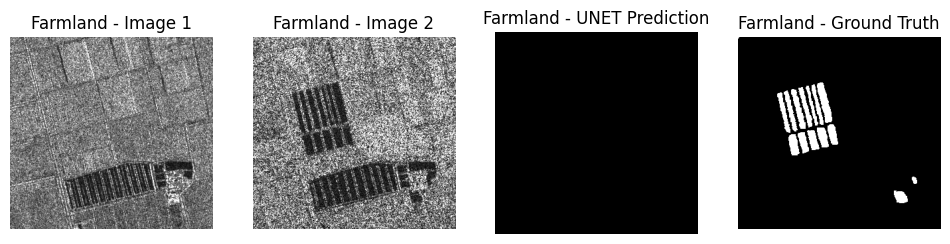

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7847 - loss: 1.0727
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7847 - loss: 0.7983
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7847 - loss: 0.6340
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7847 - loss: 0.5903
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7847 - loss: 0.5961
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7847 - loss: 0.6108
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7847 - loss: 0.6230
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7847 - loss: 0.6311
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7847 - loss: 0.6359
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7847 - loss: 0.6379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


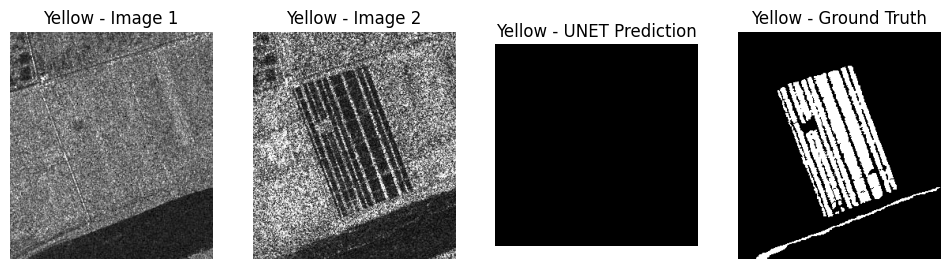

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7308 - loss: 0.6629
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7308 - loss: 0.6600
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7308 - loss: 0.6558
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7308 - loss: 0.6501
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7308 - loss: 0.6424
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7308 - loss: 0.6327
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7308 - loss: 0.6216
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7308 - loss: 0.6118
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7308 - loss: 0.6097
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7308 - loss: 0.6075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


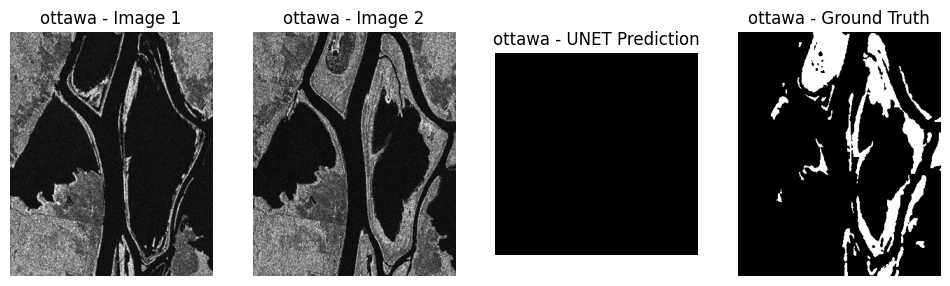

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9217 - loss: 0.3862
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9217 - loss: 0.3488
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9217 - loss: 0.2954
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9217 - loss: 0.2541
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9217 - loss: 0.2549
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9217 - loss: 0.2753
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9217 - loss: 0.2716
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9217 - loss: 0.2447
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9217 - loss: 0.2160
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9217 - loss: 0.2024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


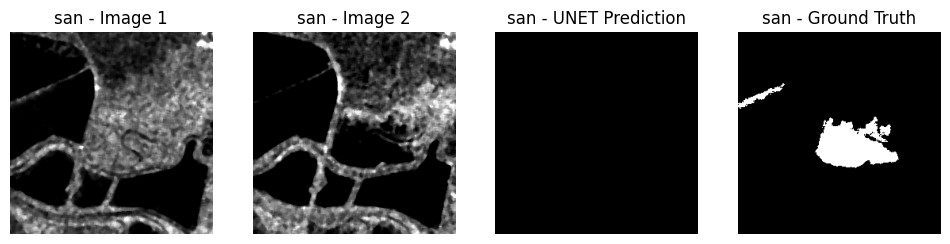

In [46]:
for ds in datasets:
    img1_path, img2_path, gt_path = get_image_paths(ds)
    if img1_path and img2_path and gt_path:
        # Prepare training data
        img1 = preprocess(img1_path)
        img2 = preprocess(img2_path)
        X = np.stack([img1, img2], axis=0)
        X = X.transpose(1,2,3,0)  # shape: (128,128,1,2)
        # For simplicity, use difference image as input
        X = np.abs(img1 - img2)
        X = np.expand_dims(X, axis=0)  # batch dimension

        Y = preprocess_gt(gt_path)
        Y = np.expand_dims(Y, axis=0)  # batch dimension

        # Train UNET for few epochs (demo)
        unet.fit(X, Y, epochs=10, verbose=1)

        # Predict
        pred = unet.predict(X)[0,:,:,0]
        pred_mask = (pred > 0.5).astype(np.uint8)*255

        # Visualize
        plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.title(f"{ds} - Image 1")
        plt.imshow(cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        plt.axis('off')

        plt.subplot(1,4,2)
        plt.title(f"{ds} - Image 2")
        plt.imshow(cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        plt.axis('off')

        plt.subplot(1,4,3)
        plt.title(f"{ds} - UNET Prediction")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1,4,4)
        plt.title(f"{ds} - Ground Truth")
        plt.imshow(cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
        plt.axis('off')

        plt.show()

In [48]:
def evaluate_unet(pred_mask, gt_path):
    # Read GT and resize to prediction size
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    gt_resized = cv2.resize(gt, (pred_mask.shape[1], pred_mask.shape[0]))

    gt_bin = (gt_resized > 0).astype(np.uint8)
    pred_bin = (pred_mask > 127).astype(np.uint8)  # 0-255 to 0/1

    TP = np.sum((pred_bin == 1) & (gt_bin == 1))
    TN = np.sum((pred_bin == 0) & (gt_bin == 0))
    FP = np.sum((pred_bin == 1) & (gt_bin == 0))
    FN = np.sum((pred_bin == 0) & (gt_bin == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-6)
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return accuracy, precision, recall, f1

In [49]:
acc, prec, rec, f1 = evaluate_unet(pred_mask, gt_path)
print(f"{ds} - UNET Metrics | Accuracy:{acc:.3f} Precision:{prec:.3f} Recall:{rec:.3f} F1:{f1:.3f}")


san - UNET Metrics | Accuracy:0.922 Precision:0.000 Recall:0.000 F1:0.000
